<a href="https://colab.research.google.com/github/dabodobo/Sistemas-Inteligentes/blob/main/Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing hand-written digits

An example showing how the scikit-learn can be used to recognize images of hand-written digits.

This example is commented in the [tutorial section of the user manual](http://scikit-learn.org/stable/tutorial/basic/tutorial.html#introduction).

In [1]:
from sklearn import datasets, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

## The digits dataset

The data that we are interested in is a set of 1797 images of digits, each one made of $8\times8$ pixels.

In [2]:
digits = datasets.load_digits()

Let's have a look at the first 8 images, stored in the `images` attribute of the
dataset. Note that each image must have the same size. For these
images, we know which digit they represent: it is given in the `target` of
the dataset.

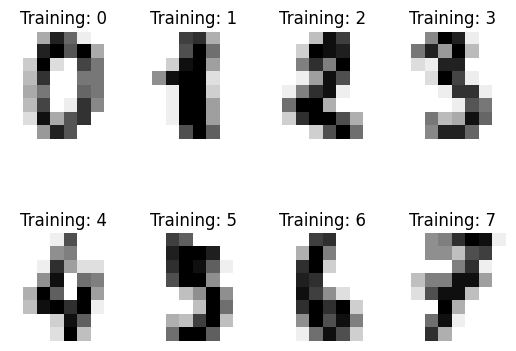

In [3]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

To apply a classifier on this data, we need to flatten the image, to
turn the data in a (samples, feature) matrix:

In [4]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

For example, the data corresponding to the image of the "0" above is:

In [5]:
data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

Each pixel is a 4-bit value, from 0 (white) to 15 (black).

## Cross-validation: evaluating network performance

Learning the parameters of the MLP and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called [**overfitting**](https://en.wikipedia.org/wiki/Overfitting). To avoid it, it is common practice  to hold out part of the available data as a test set `[X_test, y_test]`.

In scikit-learn a random split into training and test sets can be quickly computed with the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) helper function.

In [6]:
X, y = data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

## Data scaling

Standardization of datasets is a common requirement for neural networks; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In scikit-learn, the preprocessing module provides a utility class [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) that computes the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.

In [7]:
# Don't cheat - fit only on training data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# apply same transformation to test data
X_test = scaler.transform(X_test)

## Build the model

Create a [MLP object](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) with the following arguments:
* [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) solver (standard technique in [backpropagation](https://en.wikipedia.org/wiki/Backpropagation))
* one hidden layer with 5 neurons
* 4000 iterations maximum

The rest of the arguments are set to their default values (see documentation).

In [8]:
net = MLPClassifier(solver='sgd',\
                    hidden_layer_sizes=(5, ),\
                    max_iter=4000)

## Train the network

The `fit` function automatically iterates until convergence or the maximum number of iterations is reached, so you only need to execute the following cell once.

In [9]:
net.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(5,), max_iter=4000, solver='sgd')

## Analysis of the network

In scikit-learn there are some functions for measuring the accuracy of the classification.

### Classification report

The [classification_report](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) function builds a text report showing the main classification metrics:

* [precision](https://en.wikipedia.org/wiki/Precision_and_recall): ratio $\frac{tp}{tp + fp}$ where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
* [recall](https://en.wikipedia.org/wiki/Precision_and_recall): ratio $\frac{tp}{tp + fn}$ where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
* [f1-score](https://en.wikipedia.org/wiki/F1_score): a weighted average of the precision and recall, where an $F_1$ score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the $F_1$ score are equal. The formula for the $F_1$ score is: $F_1 = 2\cdot\frac{precision \cdot recall}{precision + recall}$
* support: the support is the number of occurrences of each class

In [10]:
expected = y_test
predicted = net.predict(X_test)
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        60
           1       0.92      0.85      0.89        82
           2       0.90      0.93      0.91        67
           3       0.94      0.90      0.92        73
           4       0.91      0.93      0.92        72
           5       0.88      0.95      0.91        75
           6       0.95      0.96      0.96        78
           7       0.89      0.93      0.91        72
           8       0.87      0.76      0.81        71
           9       0.84      0.90      0.87        69

    accuracy                           0.91       719
   macro avg       0.91      0.91      0.91       719
weighted avg       0.91      0.91      0.90       719



### Confusion matrix

The [`confusion_matrix`](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) function evaluates classification accuracy by computing the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

By definition, a confusion matrix $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$. Thus an optimal classification result would produce a diagonal matrix.

In [11]:
print(metrics.confusion_matrix(expected, predicted))

[[57  0  0  0  1  0  0  2  0  0]
 [ 0 70  3  0  1  0  0  0  5  3]
 [ 0  1 62  2  0  0  0  0  1  1]
 [ 0  0  4 66  0  1  0  0  0  2]
 [ 0  1  0  0 67  0  2  1  0  1]
 [ 1  0  0  2  0 71  0  0  1  0]
 [ 0  0  0  0  3  0 75  0  0  0]
 [ 0  0  0  0  1  2  0 67  0  2]
 [ 1  4  0  0  1  6  2  0 54  3]
 [ 0  0  0  0  0  1  0  5  1 62]]


### Training curve

Number of iterations during training:

In [12]:
net.n_iter_

1601

Loss curve: (currently, [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) supports only the [Cross-Entropy loss function](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression))

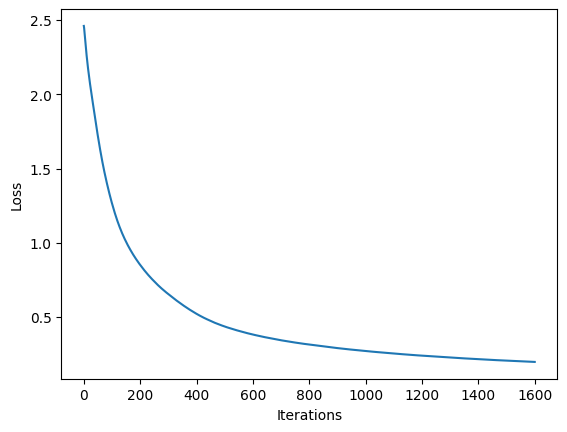

In [13]:
plt.plot(net.loss_curve_);
plt.xlabel('Iterations');
plt.ylabel('Loss');

### Samples of predictions

You can visualize the target and prediction for a few images of the dataset.

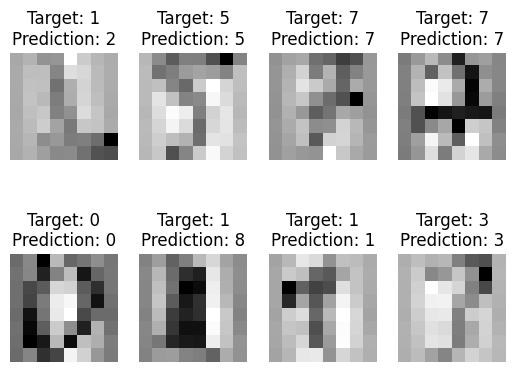

In [15]:
images_and_predictions = list(zip(X_test, predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:8]):
    plt.subplot(2, 4, index+1)
    plt.axis('off')
    plt.imshow(image.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Target: %i\nPrediction: %i' % (y_test[index],prediction))

Save the dataset, scaler and the network into files.

In [16]:
joblib.dump(scaler, 'digits_scaler.pkl')
joblib.dump(net, 'digits_net.pkl')

['digits_net.pkl']

Download the files (tested in Google Chrome, won't work with Firefox).

In [17]:
from google.colab import files
files.download('digits_scaler.pkl')
files.download('digits_net.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You can check the files of your scaler and network with [this notebook](https://github.com/RobInLabUJI/MultilayerPerceptron/blob/main/Digits_check.ipynb).

## Can the network do better?

Re-train the network several times with the same dataset, and check what is the highest value for the percentage of correct classification. You may increase the number of hidden neurons, or even use two hidden layers.

## Shuffling the dataset

You may have noticed in the previous example, that splitting the dataset differently may lead to slightly different classification results.

In order to better measure such results, you are going to test your network with **100** different test sets extracted from the dataset. For each iteration, you will compute the score of the **same** network with a **different** test set, and store the values in a list. Finally, you will compute the **mean and standard deviation** from the values in the list.

<img src="https://github.com/RobInLabUJI/MultilayerPerceptron/raw/main/img/present_gift_bonus_prize-128.png" width="32" align="right"> **BONUS**: we will set up a webpage for submitting the mean and std: the MLP with better classification performance will receive an extra bonus!!!

#### Create a new notebook with the following statements:

* Load your scaler and network files
* Load the digits dataset
* Iterate 100 times:
  * Generate a new test set
  * Compute the net score
* Compute the mean and standard deviation of the values
* Print the result

**REMEMBER**: for the **workshop of sessions 2-4** you will submit the <tt>pkl</tt> files for the scaler and neural network that solves the digits problem, and the <tt>ipynb</tt> file with the 100-iteration loop for computing the average net score.